In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score, accuracy_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Load the dataset
wine_dataset = load_wine()

# Access the feature names
feature_names = wine_dataset.feature_names

# Access the data and target
data = wine_dataset.data
target = wine_dataset.target

# Convert data and target to a Pandas DataFrame
wine_df = pd.DataFrame(data, columns=feature_names)
wine_df['target'] = target

np.random.seed(42)

print(wine_df.info())
print(wine_df.shape)

# Normalize features for better performance
min_max_scaler = MinMaxScaler()
wineX = min_max_scaler.fit_transform(wine_df.drop("target", axis=1).values)
wineY = wine_df["target"].values

# Perform a stratified split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(wineX, wineY, test_size=0.2, stratify=wineY, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

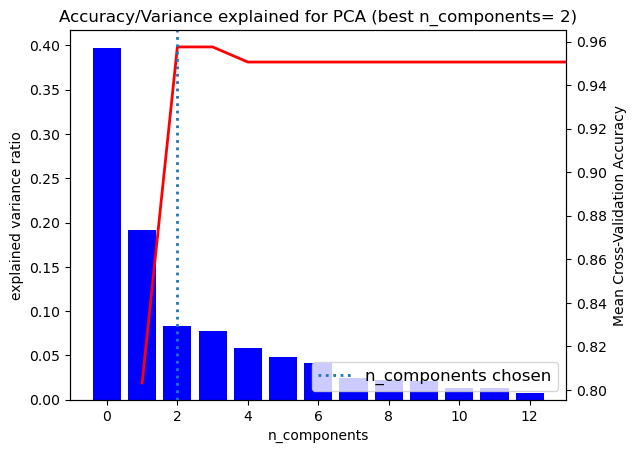

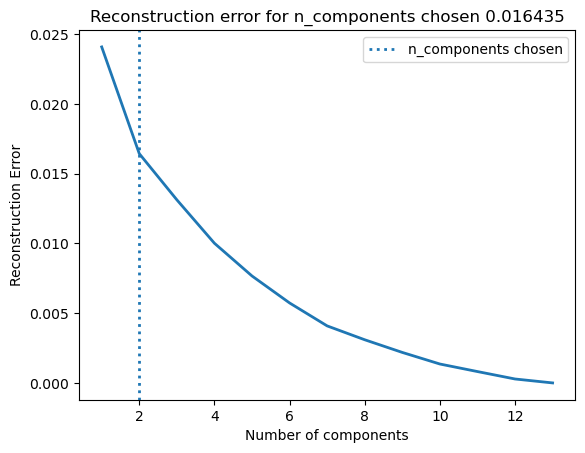

In [3]:
# Initialize Decision Tree Classifier
decisiontree = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)

# Initialize PCA
pca = PCA()

# Create a pipeline with PCA and Decision Tree Classifier
pipe = Pipeline(steps=[('pca', pca), ('decisionTree', decisiontree)])

# Fit PCA on the training data
pca.fit(X_train)

# Plot the PCA explained variance ratio
fig, ax = plt.subplots()
ax.bar(np.arange(X_train.shape[1]), pca.explained_variance_ratio_, linewidth=2, color='blue')
plt.axis('tight')
plt.xlabel('n_components')
ax.set_ylabel('explained variance ratio')

# Perform Grid Search to find the optimal number of components for PCA
n_components = range(1, X_train.shape[1]+1)
gridSearch = GridSearchCV(pipe, dict(pca__n_components=n_components), cv=3)
gridSearch.fit(X_train, y_train)

# Retrieve results from the grid search
results = gridSearch.cv_results_

# Plotting the cross-validation accuracy for each number of components
ax1 = ax.twinx()
ax1.plot(n_components, results['mean_test_score'], linewidth=2, color='red')
ax1.set_ylabel('Mean Cross-Validation Accuracy')
ax1.axvline(gridSearch.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen', linewidth=2)

plt.legend(prop=dict(size=12))
plt.title(f'Accuracy/Variance explained for PCA (best n_components= {gridSearch.best_estimator_.named_steps["pca"].n_components})')
plt.show()

# Reducing the dimensions with the optimal number of components
pca_optimal = PCA(n_components=gridSearch.best_estimator_.named_steps['pca'].n_components)
pca_optimal.fit(X_train)
X_train_transformed = pca_optimal.transform(X_train)

reconstruction_error = []
for comp in n_components:
    pca = PCA(n_components=comp)
    X_transformed = pca.fit_transform(X_train)
    X_projected = pca.inverse_transform(X_transformed)
    reconstruction_error.append(mean_squared_error(X_train, X_projected))

    if comp == gridSearch.best_estimator_.named_steps['pca'].n_components:
        chosen_error = mean_squared_error(X_train, X_projected)

# Plot Reconstruction Error
fig2, ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth=2)
ax2.axvline(gridSearch.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title(f'Reconstruction error for n_components chosen {chosen_error:.6f}')
plt.legend()
plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


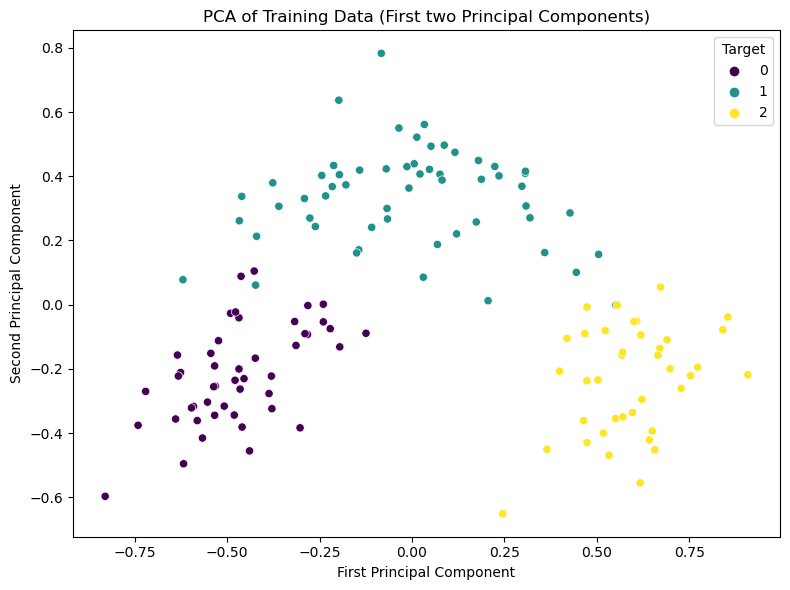

In [4]:
# Let's reduce the training data to the first two principal components for visualization
pca_for_visualization = PCA(n_components=2)
X_train_pca_visualization = pca_for_visualization.fit_transform(X_train)

# Now we create a DataFrame with the first two components
df_pca = pd.DataFrame(X_train_pca_visualization, columns=['First Principal Component', 'Second Principal Component'])

# Add the target variable for coloring the data points
df_pca['target'] = y_train

# Visualize the first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, 
                x='First Principal Component', 
                y='Second Principal Component', 
                hue='target',
                palette='viridis')

plt.title('PCA of Training Data (First two Principal Components)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
# Move the legend out of the plot
plt.legend(title='Target', bbox_to_anchor=(1, 1))
plt.tight_layout()  # This will adjust spacing to accommodate the legend
plt.show()


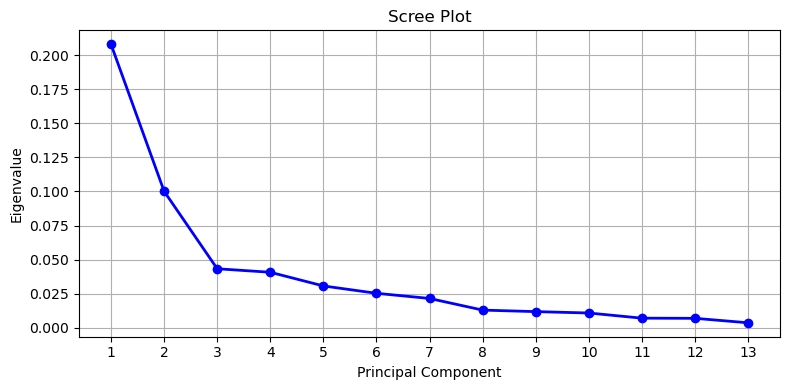

In [5]:
# Fit PCA on the training data without reducing dimensionality
# to see the explained variance of all the components
pca = PCA().fit(X_train)

# Eigenvalues (explained_variance_) vs. Principal Components Plot (Scree Plot)
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
# Setting x-ticks as component numbers
plt.xticks(np.arange(1, len(pca.explained_variance_) + 1))
plt.grid(True)
plt.tight_layout()  # This adjusts the plot to ensure everything fits without overlapping
plt.show()


In [6]:
decision_tree_classifier = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)

# Perform cross-validation
cv_scores = cross_val_score(decision_tree_classifier, X_train, y_train, cv=5)

# Print cross-validation scores
print(f"Decision Tree cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores)}")


Decision Tree cross-validation scores: [0.86206897 0.89655172 0.92857143 0.89285714 1.        ]
Mean CV accuracy: 0.9160098522167488


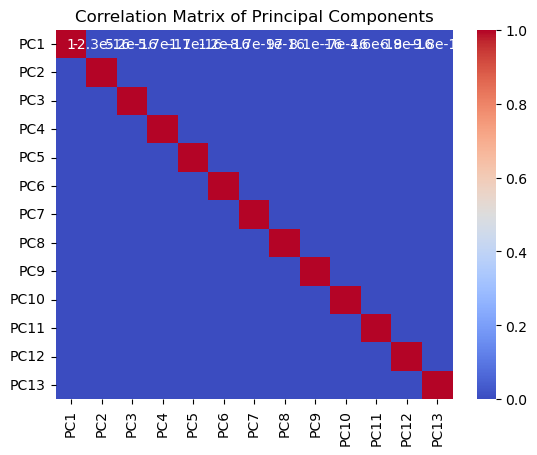

In [7]:
# Fit PCA on the training data
pca = PCA().fit(X_train)
X_train_pca = pca.transform(X_train)

# Create DataFrame with the PCA features
# Naming the columns as 'PC1', 'PC2', ..., 'PCn'
pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i}' for i in range(1, X_train_pca.shape[1] + 1)])

# Calculate the correlation matrix - Expect near-zero off-diagonal elements due to orthogonality of principal components
corr_matrix = pca_df.corr()

# Plotting the correlation matrix
# In the case of PCA, the correlation matrix should ideally be an identity matrix
# because PCA transforms the data into components that are uncorrelated
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Principal Components')
plt.show()

In [8]:
for i, exp_var in enumerate(pca.explained_variance_ratio_):
    print(f"Principal Component {i+1}: {exp_var:.4f}")


Principal Component 1: 0.3974
Principal Component 2: 0.1914
Principal Component 3: 0.0828
Principal Component 4: 0.0779
Principal Component 5: 0.0587
Principal Component 6: 0.0484
Principal Component 7: 0.0412
Principal Component 8: 0.0249
Principal Component 9: 0.0227
Principal Component 10: 0.0208
Principal Component 11: 0.0135
Principal Component 12: 0.0133
Principal Component 13: 0.0071


In [9]:
# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Print cumulative explained variance for each number of components
for i, cum_var in enumerate(cumulative_explained_variance):
    print(f"Cumulative Explained Variance up to component {i+1}: {cum_var:.4f}")

Cumulative Explained Variance up to component 1: 0.3974
Cumulative Explained Variance up to component 2: 0.5888
Cumulative Explained Variance up to component 3: 0.6716
Cumulative Explained Variance up to component 4: 0.7495
Cumulative Explained Variance up to component 5: 0.8082
Cumulative Explained Variance up to component 6: 0.8566
Cumulative Explained Variance up to component 7: 0.8977
Cumulative Explained Variance up to component 8: 0.9226
Cumulative Explained Variance up to component 9: 0.9453
Cumulative Explained Variance up to component 10: 0.9661
Cumulative Explained Variance up to component 11: 0.9796
Cumulative Explained Variance up to component 12: 0.9929
Cumulative Explained Variance up to component 13: 1.0000


In [10]:
# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% of the variance
num_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components that explain at least 95% of variance: {num_components_95}")

Number of components that explain at least 95% of variance: 10


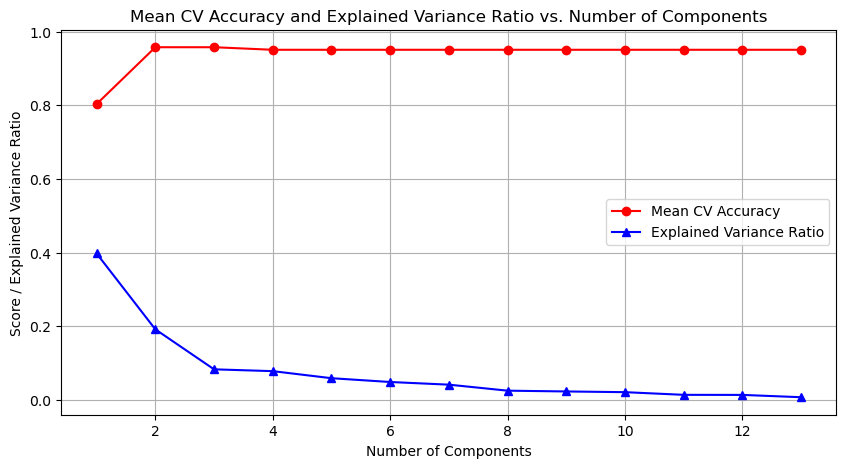

In [11]:
# Plotting the Mean Cross-Validation Accuracy and Explained Variance Ratio
plt.figure(figsize=(10, 5))

# Mean Cross-Validation Accuracy
plt.plot(n_components, results['mean_test_score'], label='Mean CV Accuracy', color='red', marker='o')

# Explained Variance Ratio (use the fitted PCA on the training set)
plt.plot(n_components, pca.explained_variance_ratio_, label='Explained Variance Ratio', color='blue', marker='^')

plt.xlabel('Number of Components')
plt.ylabel('Score / Explained Variance Ratio')
plt.title('Mean CV Accuracy and Explained Variance Ratio vs. Number of Components')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [12]:
#EM Clustering after PCA

In [13]:
# Assuming you have already found the optimal number of PCA components above
optimal_n_components = gridSearch.best_estimator_.named_steps['pca'].n_components

# Fit PCA with the optimal number of components
pca_optimal = PCA(n_components=optimal_n_components)
X_train_pca = pca_optimal.fit_transform(X_train)

# Now apply EM clustering on the PCA-transformed data
clusters = list(range(2, 31, 1))
silh_scores_pca = {}
homog_scores_pca = {}
log_likelihood_scores_pca = {}

for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=42, n_init=5).fit(X_train_pca)
    labels_pca = gmm.predict(X_train_pca)
    
    sil_coeff_pca = silhouette_score(X_train_pca, labels_pca, metric='euclidean')
    homog_score_pca = homogeneity_score(y_train, labels_pca)
    log_likelihood_pca = gmm.score(X_train_pca)  # Compute average log likelihood on PCA-transformed data
    
    silh_scores_pca[cluster] = sil_coeff_pca
    homog_scores_pca[cluster] = homog_score_pca
    log_likelihood_scores_pca[cluster] = log_likelihood_pca
    
    print(f"For n_clusters={cluster} (PCA): The Silhouette Coefficient is {sil_coeff_pca}")
    print(f"For n_clusters={cluster} (PCA): The homogeneity_score is {homog_score_pca}")
    print(f"For n_clusters={cluster} (PCA): The average log_likelihood score is {log_likelihood_pca}")


For n_clusters=2 (PCA): The Silhouette Coefficient is 0.49013230179065226
For n_clusters=2 (PCA): The homogeneity_score is 0.39250619712206797
For n_clusters=2 (PCA): The average log_likelihood score is -0.3889980457658982
For n_clusters=3 (PCA): The Silhouette Coefficient is 0.5816055961424289
For n_clusters=3 (PCA): The homogeneity_score is 0.8761209922853177
For n_clusters=3 (PCA): The average log_likelihood score is -0.2102452296753998
For n_clusters=4 (PCA): The Silhouette Coefficient is 0.4886207016783126
For n_clusters=4 (PCA): The homogeneity_score is 0.9245895776775962
For n_clusters=4 (PCA): The average log_likelihood score is -0.15554284986507588
For n_clusters=5 (PCA): The Silhouette Coefficient is 0.4660115847879864
For n_clusters=5 (PCA): The homogeneity_score is 0.9298570430062914
For n_clusters=5 (PCA): The average log_likelihood score is -0.11539609452993198
For n_clusters=6 (PCA): The Silhouette Coefficient is 0.3673359436300999
For n_clusters=6 (PCA): The homogeneity

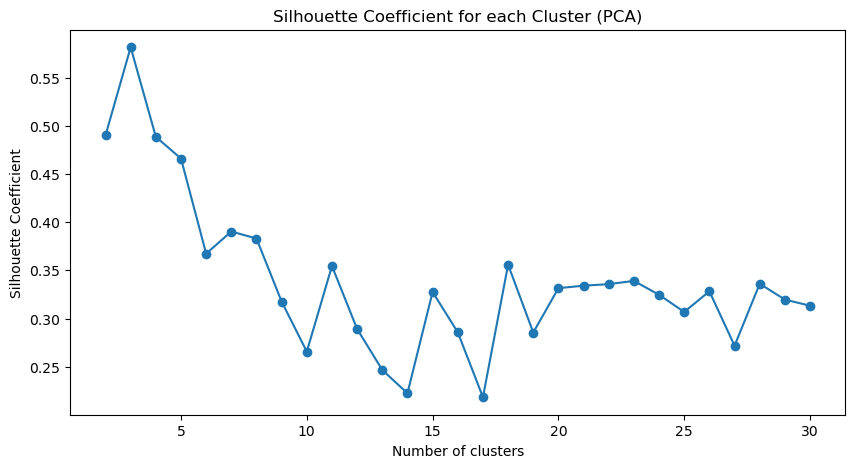

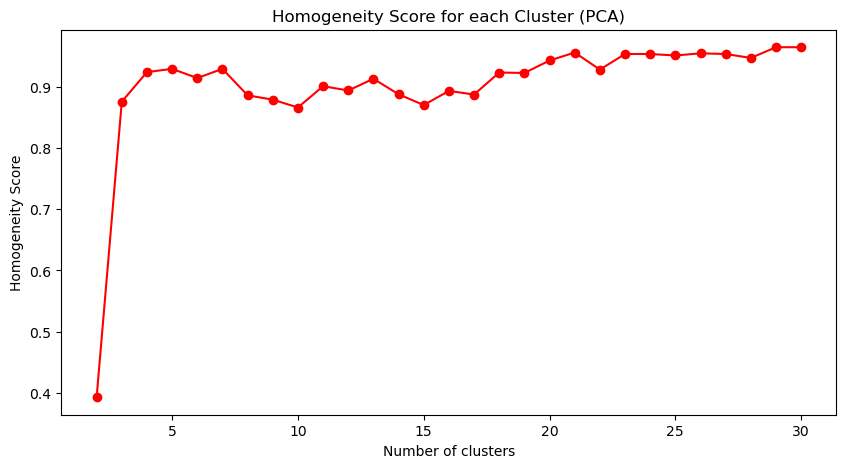

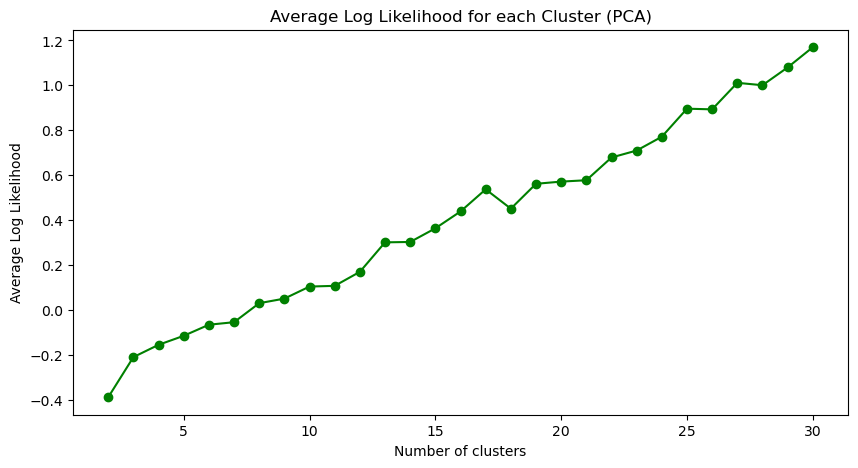

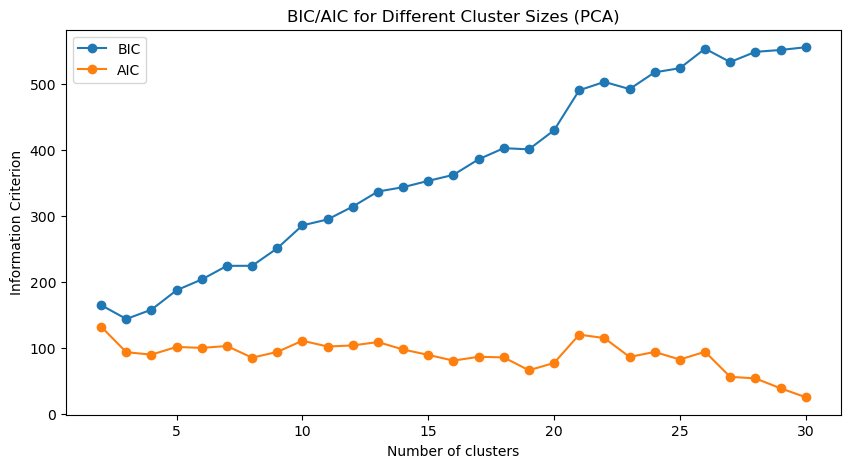

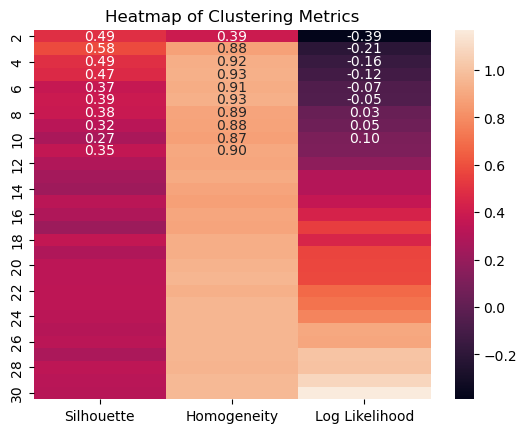

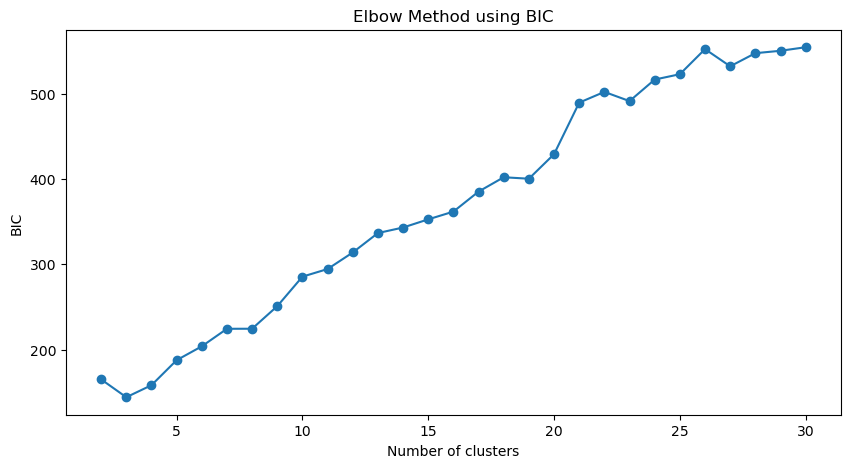

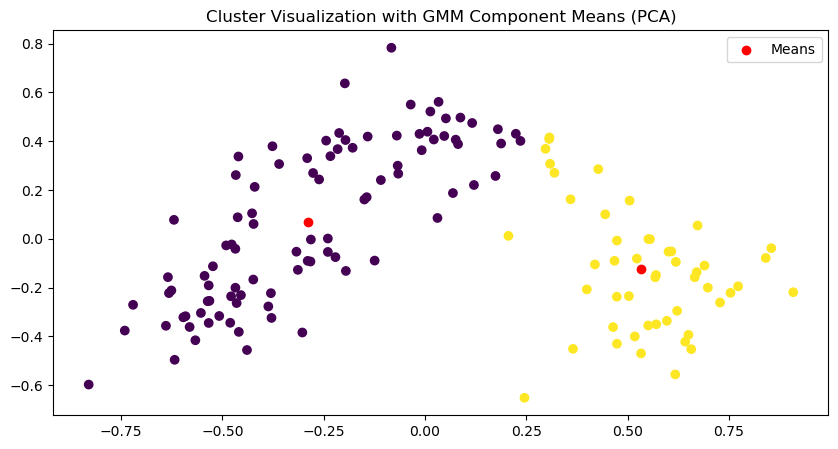

In [14]:
# Silhouette Coefficient Plot
plt.figure(figsize=(10, 5))
plt.plot(list(silh_scores_pca.keys()), list(silh_scores_pca.values()), marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient for each Cluster (PCA)')
plt.show()

# Homogeneity Score Plot
plt.figure(figsize=(10, 5))
plt.plot(list(homog_scores_pca.keys()), list(homog_scores_pca.values()), marker='o', color='r')
plt.xlabel('Number of clusters')
plt.ylabel('Homogeneity Score')
plt.title('Homogeneity Score for each Cluster (PCA)')
plt.show()

# Average Log Likelihood Plot
plt.figure(figsize=(10, 5))
plt.plot(list(log_likelihood_scores_pca.keys()), list(log_likelihood_scores_pca.values()), marker='o', color='g')
plt.xlabel('Number of clusters')
plt.ylabel('Average Log Likelihood')
plt.title('Average Log Likelihood for each Cluster (PCA)')
plt.show()

# BIC and AIC for Clustering Plot
bics, aics = [], []
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, random_state=42).fit(X_train_pca)
    bics.append(gmm.bic(X_train_pca))
    aics.append(gmm.aic(X_train_pca))

plt.figure(figsize=(10, 5))
plt.plot(clusters, bics, label='BIC', marker='o')
plt.plot(clusters, aics, label='AIC', marker='o')
plt.legend()
plt.xlabel('Number of clusters')
plt.ylabel('Information Criterion')
plt.title('BIC/AIC for Different Cluster Sizes (PCA)')
plt.show()

# Heatmaps of Clustering Metrics
# Combine all the scores into a DataFrame for the heatmap
import pandas as pd
scores_df = pd.DataFrame({
    'Silhouette': silh_scores_pca,
    'Homogeneity': homog_scores_pca,
    'Log Likelihood': log_likelihood_scores_pca
})
sns.heatmap(scores_df, annot=True, fmt=".2f")
plt.title('Heatmap of Clustering Metrics')
plt.show()

# Elbow Method Visualization using BIC
plt.figure(figsize=(10, 5))
plt.plot(clusters, bics, label='BIC', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('Elbow Method using BIC')
plt.show()

# Plot of GMM Means on 2D PCA plane
gmm = GaussianMixture(n_components=optimal_n_components, random_state=42).fit(X_train_pca)
plt.figure(figsize=(10, 5))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=gmm.predict(X_train_pca), cmap='viridis', zorder=2)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', label='Means', zorder=3)
plt.title('Cluster Visualization with GMM Component Means (PCA)')
plt.legend()
plt.show()

Optimal number of clusters: 5
The Silhouette Coefficient for optimal clustering is 0.2131511216076998
The homogeneity_score for optimal clustering is 0.8349237849594702
The average log_likelihood for optimal clustering is 6.598880853144744


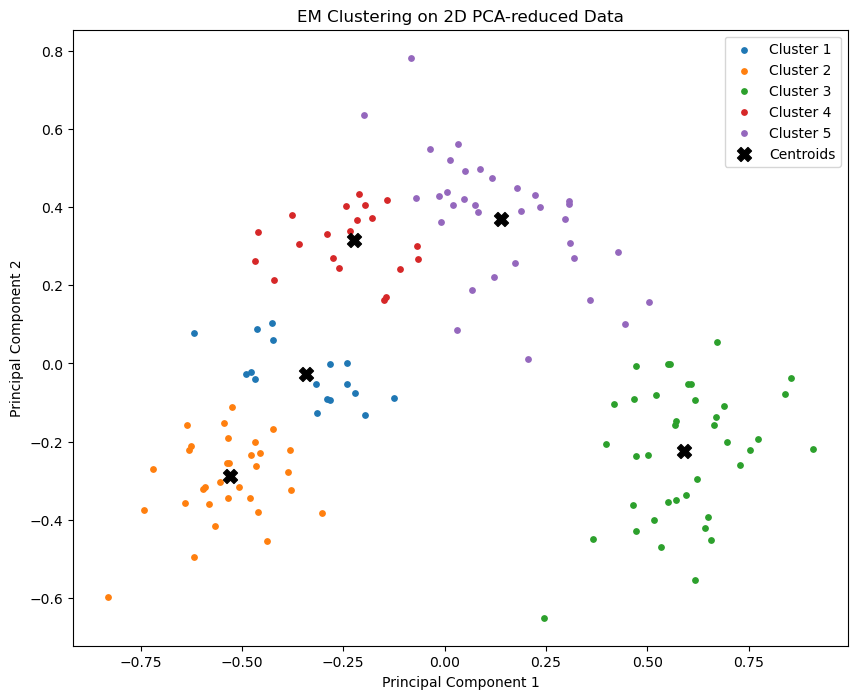

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score

# Assuming 'X_train' is your training set and 'y_train' are the true labels

# Perform PCA to reduce dimensionality for clustering
n_components_pca = 10  # Number of components that explain at least 95% of variance
pca_optimal = PCA(n_components=n_components_pca)
X_train_pca = pca_optimal.fit_transform(X_train)

# Apply EM clustering on the PCA-transformed data
n_components_gmm = 5  # Optimal number of clusters determined from your results
gmm = GaussianMixture(n_components=n_components_gmm, max_iter=100, random_state=42, n_init=5).fit(X_train_pca)
labels_pca = gmm.predict(X_train_pca)

# Compute metrics for the optimal clustering solution
sil_coeff_pca = silhouette_score(X_train_pca, labels_pca, metric='euclidean')
homog_score_pca = homogeneity_score(y_train, labels_pca)
log_likelihood_pca = gmm.score(X_train_pca)  # Average log likelihood on PCA-transformed data

print(f"Optimal number of clusters: {n_components_gmm}")
print(f"The Silhouette Coefficient for optimal clustering is {sil_coeff_pca}")
print(f"The homogeneity_score for optimal clustering is {homog_score_pca}")
print(f"The average log_likelihood for optimal clustering is {log_likelihood_pca}")

# Reduce dimensionality to 2D for visualization
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)

# Fit the GMM on the 2D PCA-reduced data
gmm.fit(X_train_pca_2d)

# Predict the cluster labels
labels = gmm.predict(X_train_pca_2d)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(n_components_gmm):
    # Select data points that belong to the current cluster
    points = X_train_pca_2d[labels == i]
    plt.scatter(points[:, 0], points[:, 1], s=15, label=f'Cluster {i+1}')

# Plot the cluster centroids
centroids = gmm.means_
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, color='black', label='Centroids', marker='X')

plt.title('EM Clustering on 2D PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

# Assuming you have the predicted labels from GMM and the true labels `y_train`

# Calculate the confusion matrix
cm = confusion_matrix(y_train, labels_pca)

# Use the Hungarian algorithm to find the best alignment for the clustering labels
row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
maximized_cm = cm[row_ind[:, None], col_ind]

# Calculate "accuracy"
accuracy = np.trace(maximized_cm) / np.sum(maximized_cm)

print(f"Aligned Accuracy of Clustering: {accuracy}")

Aligned Accuracy of Clustering: 0.7394366197183099


Sum of Squared Errors for KMeans with 3 clusters: 7.90223864878976


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in

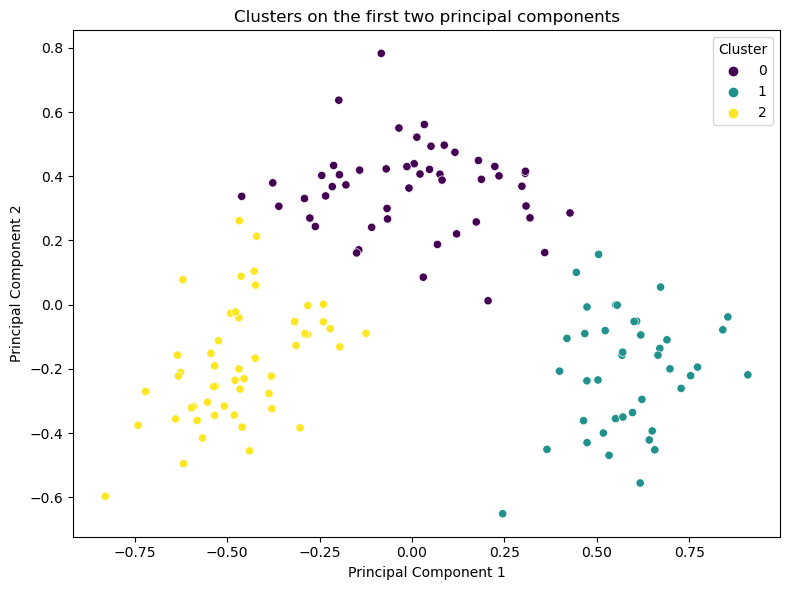

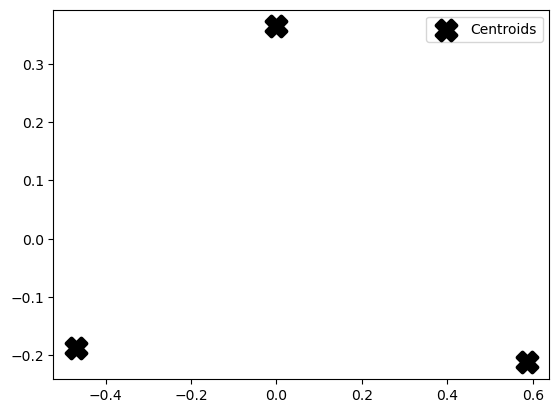

In [20]:
from sklearn.cluster import KMeans

# Assuming `X_train_transformed` is your data transformed by PCA with the optimal number of components
# And since you've determined the optimal number of clusters to be 3

# Apply KMeans clustering to the PCA-reduced data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train_transformed)

# Calculate Sum of Squared Errors (SSE)
sse = kmeans.inertia_
print(f"Sum of Squared Errors for KMeans with 3 clusters: {sse}")

# Add the cluster labels to your DataFrame for visualization
pca_df['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title('Clusters on the first two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()  # This will adjust spacing to accommodate the legend
plt.show()

# If you want to plot the centroids as well:
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, linewidths=3, color='black', zorder=10, label='Centroids')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X_train_transformed, clusters)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.5813694165159355


In [22]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(X_train_transformed, clusters)
print(f"Calinski-Harabasz Index: {ch_score}")


Calinski-Harabasz Index: 312.6101247084123


In [23]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(X_train_transformed, clusters)
print(f"Davies-Bouldin Index: {db_score}")


Davies-Bouldin Index: 0.5688227927118614


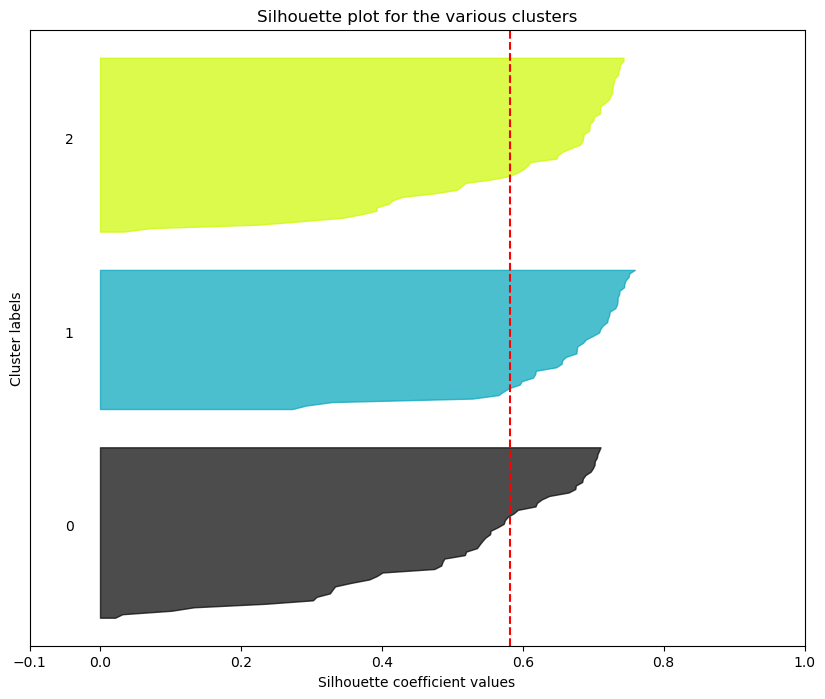

Silhouette Score: 0.5813694165159355


In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

# Assuming the rest of your code is defined above as given

# Calculate silhouette scores
silhouette_vals = silhouette_samples(X_train_transformed, clusters)
silhouette_avg = silhouette_score(X_train_transformed, clusters)

# Silhouette plot
fig, ax = plt.subplots(figsize=(10, 8))
y_lower = 10  # start at 10 for better spacing
n_clusters = 3

for i in range(n_clusters):
    ith_cluster_silhouette_vals = silhouette_vals[clusters == i]
    ith_cluster_silhouette_vals.sort()
    
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # add 10 for the 0 samples gap

ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title('Silhouette plot for the various clusters')
ax.set_xlabel('Silhouette coefficient values')
ax.set_ylabel('Cluster labels')
ax.set_yticks([])  # Clear the y-axis labels
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlim([-0.1, 1])

plt.show()

print(f"Silhouette Score: {silhouette_avg}")

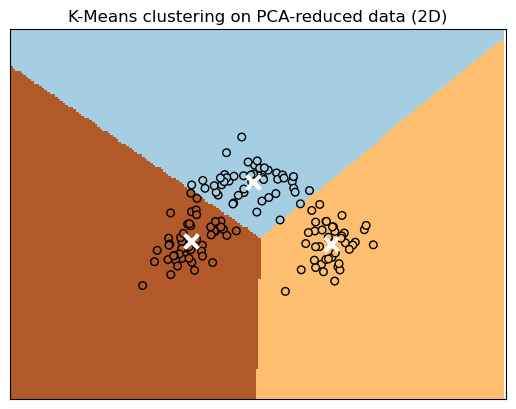

In [25]:
# Assuming `pca_for_visualization` is your PCA reduced to two components
h = .02  # step size in the mesh
x_min, x_max = X_train_transformed[:, 0].min() - 1, X_train_transformed[:, 0].max() + 1
y_min, y_max = X_train_transformed[:, 1].min() - 1, X_train_transformed[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in the mesh using our trained model
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect='auto', origin='lower')

plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], s=30, c=clusters, cmap=plt.cm.Paired, edgecolors='k')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=3, color='w', zorder=10)
plt.title('K-Means clustering on PCA-reduced data (2D)')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Silhouette Score: 0.3085


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

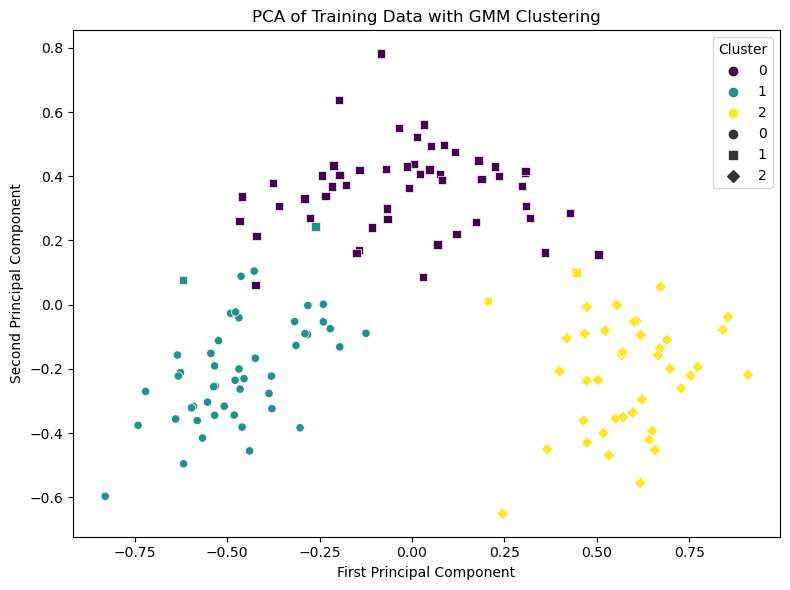

In [17]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Assuming X_train_pca contains the training data reduced to the principal components
# that you want to use for the clustering

# Choose the number of clusters (e.g., number of unique values in y_train)
n_clusters = len(np.unique(y_train))

# Initialize Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)

# Fit the model on the PCA-transformed data
gmm.fit(X_train_pca)

# Predict the cluster labels
cluster_labels = gmm.predict(X_train_pca)

# Evaluate clustering performance using silhouette score
silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.4f}')

# Optionally, add the cluster labels to your PCA DataFrame for visualization
df_pca['cluster'] = cluster_labels

# Visualize the clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, 
                x='First Principal Component', 
                y='Second Principal Component', 
                hue='cluster',
                palette='viridis',
                style=y_train, # This allows you to distinguish the true classes
                markers=['o', 's', 'D']) # Change markers for better visual distinction if needed

plt.title('PCA of Training Data with GMM Clustering')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

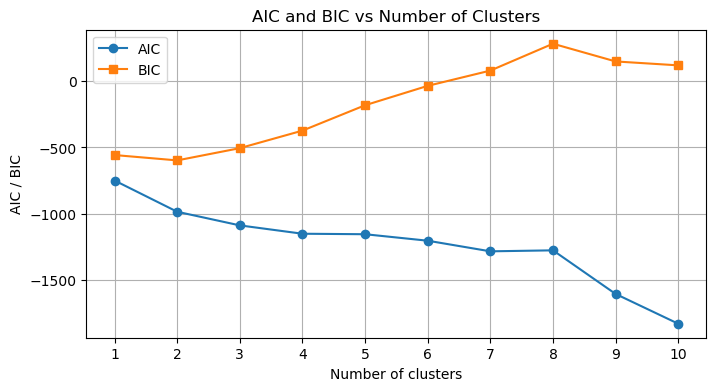

Optimal number of clusters (BIC): 2
Optimal number of clusters (AIC): 10


In [18]:
# Calculate AIC and BIC for a range of number of clusters
n_clusters_range = range(1, 11)  # For example, testing 1 through 10 clusters
aic_values = []
bic_values = []

for n_clusters in n_clusters_range:
    # Initialize a Gaussian Mixture Model with the current number of clusters
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    
    # Fit the model
    gmm.fit(X_train_pca)
    
    # Append the AIC and BIC values to their respective lists
    aic_values.append(gmm.aic(X_train_pca))
    bic_values.append(gmm.bic(X_train_pca))

# Plot the AIC and BIC values
plt.figure(figsize=(8, 4))
plt.plot(n_clusters_range, aic_values, label='AIC', marker='o')
plt.plot(n_clusters_range, bic_values, label='BIC', marker='s')
plt.xlabel('Number of clusters')
plt.ylabel('AIC / BIC')
plt.xticks(n_clusters_range)
plt.title('AIC and BIC vs Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

# Find the number of clusters that gives the lowest BIC (you can also use AIC)
optimal_clusters_bic = n_clusters_range[np.argmin(bic_values)]
print(f"Optimal number of clusters (BIC): {optimal_clusters_bic}")

# Find the number of clusters that gives the lowest AIC
optimal_clusters_aic = n_clusters_range[np.argmin(aic_values)]
print(f"Optimal number of clusters (AIC): {optimal_clusters_aic}")

In [19]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_train_pca, gmm.predict(X_train_pca))
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.1561444813952722


In [21]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(X_train_pca, gmm.predict(X_train_pca))
print(f'Calinski-Harabasz Score: {ch_score}')

Calinski-Harabasz Score: 29.24194410884998


In [22]:
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(X_train_pca, gmm.predict(X_train_pca))
print(f'Davies-Bouldin Score: {db_score}')

Davies-Bouldin Score: 1.6884459688099285


In [23]:
from sklearn.metrics import homogeneity_score
homogeneity = homogeneity_score(y_train, gmm.predict(X_train_pca))
print(f'Homogeneity Score: {homogeneity}')

Homogeneity Score: 0.8863944880804473


In [24]:
from sklearn.metrics import completeness_score
completeness = completeness_score(y_train, gmm.predict(X_train_pca))
print(f'Completeness Score: {completeness}')

Completeness Score: 0.4580863869580281


In [25]:
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y_train, gmm.predict(X_train_pca))
print(f'Adjusted Rand Index: {ari}')

Adjusted Rand Index: 0.4231075841629257


In [31]:
#K-Means

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

Number of clusters: 2, SSE: 47.87310935617174, Silhouette Score: 0.3068853745580706
Number of clusters: 3, SSE: 35.42030328269823, Silhouette Score: 0.31500213729727783
Number of clusters: 4, SSE: 32.353391577344304, Silhouette Score: 0.28748097843265524
Number of clusters: 5, SSE: 30.58205263555734, Silhouette Score: 0.24679937832669196
Number of clusters: 6, SSE: 28.509197218281734, Silhouette Score: 0.21921467548592732
Number of clusters: 7, SSE: 26.893071582099026, Silhouette Score: 0.20923726084882915
Number of clusters: 8, SSE: 25.386469856916694, Silhouette Score: 0.14919087750146284
Number of clusters: 9, SSE: 24.669520653219173, Silhouette Score: 0.14745245589890443
Number of clusters: 10, SSE: 22.802454129386824, Silhouette Score: 0.1545348763782678


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


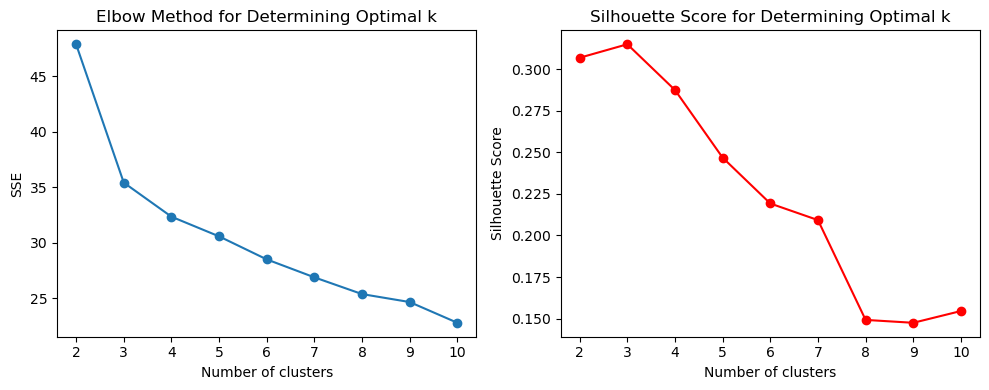

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Optimal number of clusters based on silhouette score: 3


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


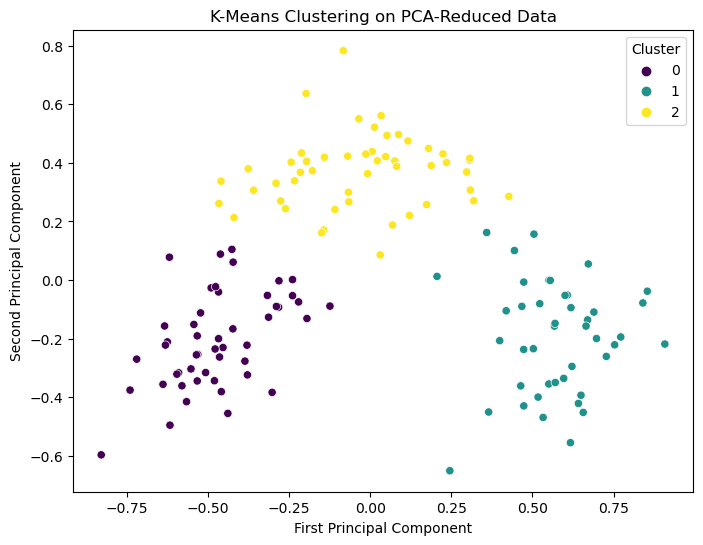

In [34]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
# First, reduce the training data to the 10 principal components
pca = PCA(n_components=num_components_95)  # num_components_95 is 10 as per your PCA results
X_train_pca = pca.fit_transform(X_train)

# Apply the elbow method along with silhouette score to find the optimal number of clusters
sse = []
silhouette_scores = []
for k in range(2, 11):  # Start at 2 clusters for silhouette score
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    sse.append(kmeans.inertia_)
    
    # Compute the silhouette score
    score = silhouette_score(X_train_pca, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Number of clusters: {k}, SSE: {kmeans.inertia_}, Silhouette Score: {score}")

# Find the optimal k using silhouette score
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 because range starts at 2

# Plot SSE for each *k*
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.xticks(range(2, 11))

# Plot Silhouette scores for each *k*
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score for Determining Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))

plt.tight_layout()
plt.show()

print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

# Run K-Means with the optimal number of clusters determined
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_train_pca)

# Adding the predicted clusters to the original PCA DataFrame (for visualization)
df_pca['Cluster'] = kmeans.labels_

# Visualize the clusters in the context of the first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, 
                x='First Principal Component', 
                y='Second Principal Component', 
                hue='Cluster',
                palette='viridis')
plt.title('K-Means Clustering on PCA-Reduced Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(title='Cluster')
plt.show()

For n_clusters = 3, the average silhouette_score is : 0.31500213729727783


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


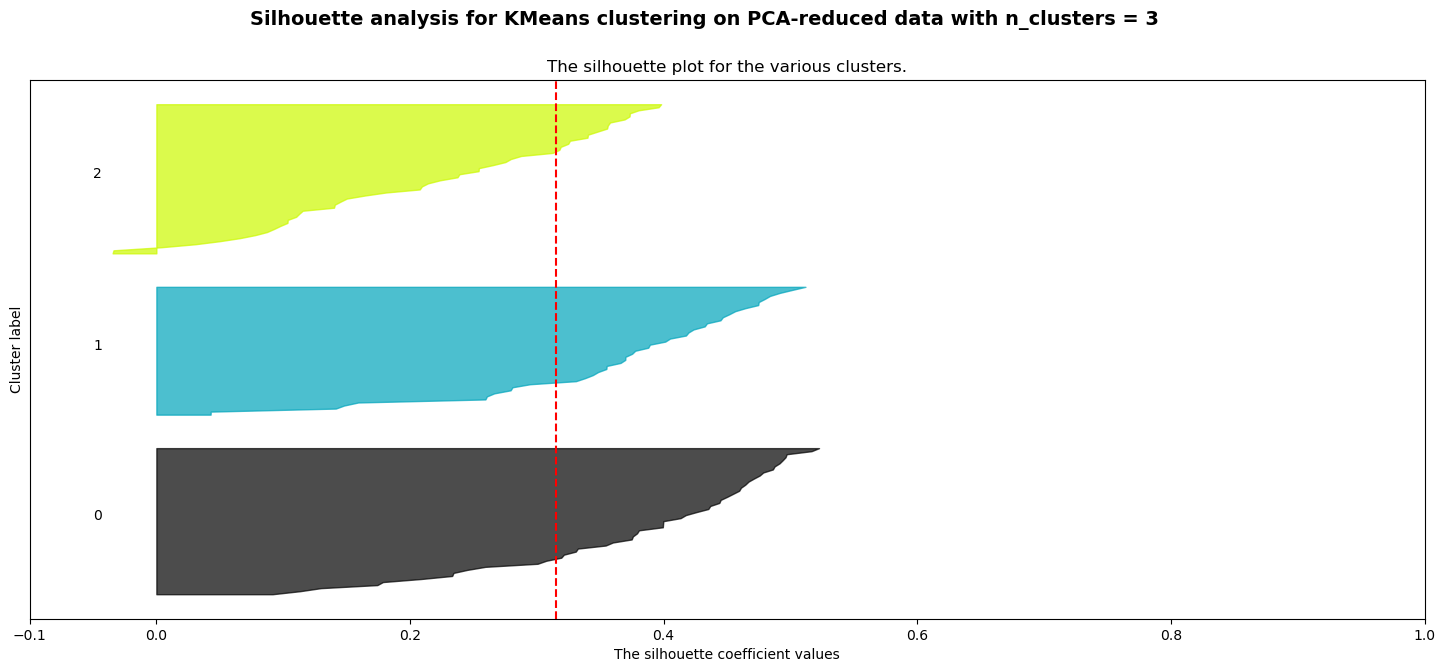

In [35]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Assume `optimal_k` is the optimal cluster count found earlier
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_pca)

# Silhouette analysis
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# The silhouette_score gives the average value for all samples
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
print(f"For n_clusters = {optimal_k}, the average silhouette_score is : {silhouette_avg}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_train_pca, cluster_labels)

y_lower = 10
for i in range(optimal_k):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / optimal_k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(f"Silhouette analysis for KMeans clustering on PCA-reduced data with n_clusters = {optimal_k}", fontsize=14, fontweight='bold')

plt.show()